In [1]:
import time
import numpy as np
import pymc3 as pm
import pandas as pd
from tqdm import tqdm
import os
#import math 
from numba import jit

import arviz as az
import matplotlib.pyplot as plt

import theano
import theano.tensor as t
from scipy.integrate import solve_ivp

THEANO_FLAGS = 'optimizer=fast_compile', 'exception_verbosity=high'
SEED = 1234

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Leitura e tratamento dos arquivos csv gerados

dfS2 = pd.read_csv(r"C:\Users\thais\Downloads\sensiveis-dados_reais\sensiveis4000_dados-reais.csv", sep=';', header=None)
dfS2.columns = ['hours', 'cell_index']
dfS2 = dfS2.replace({',':'.'}, regex=True)
dfS2 = dfS2.astype(float)
dfS2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hours       156 non-null    float64
 1   cell_index  156 non-null    float64
dtypes: float64(2)
memory usage: 2.6 KB


In [3]:
#obter somente menores do que 97 horas

dfs2 = dfS2[dfS2['hours'] < 97]

In [4]:
xdados2 = np.array(dfs2['hours'].values)
ydados2 = np.array(dfs2['cell_index'].values)

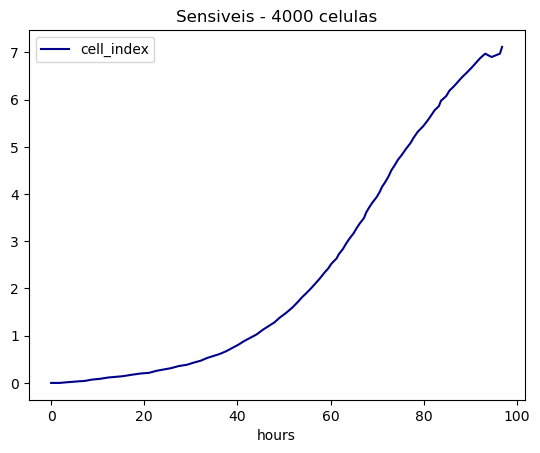

In [5]:
dfs2.plot(x='hours', y='cell_index', c='DarkBlue', title='Sensiveis - 4000 celulas')
plt.show()

In [6]:
def model01(t, X, s0, taus, K):
    S = X
    
    dSdt = 1/taus * S * (np.log(K/(S)))
    
    return dSdt

In [7]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dmatrix])
def wrapper1(time_exp2, taus, K, s0):
    t_span2 = (0.0, time_exp2.max())
    
    y01 = np.array([s0])    
    y_model1 =  solve_ivp(
        fun = lambda t, y: model01(t, y, taus=taus, K=K, s0=s0),
        t_span=t_span2,
        y0=y01,
        t_eval=time_exp2,
        rtol=1e-5,
        method='LSODA'    
    )
    
    simulated_time1 = y_model1.t
    simulated_ode_solution1 = y_model1.y
    S1 = simulated_ode_solution1

    return S1

In [8]:
print('\n*** Performing Bayesian Calibration ***')
print('-- Running Monte Carlo Simulations')

y_conc = ydados2 
observations = y_conc #ydados2
draws = 5000
start_time = time.time()

with pm.Model() as model_smc:

#Priors
    
    s0 = pm.Uniform('s0', lower=0.000001, upper=1.0)
    taus = pm.Uniform('taus', lower=25.0, upper=70.0)
    K = pm.Uniform('K', lower=2.0, upper=30.0)
    sigma2 = pm.Uniform('sigma2', lower=0.0001, upper=5.0)

    #simulando para 1-1, 3-1, 7-1
    fitting_model = pm.Deterministic(
        'model01',
        wrapper1(
            theano.shared(xdados2),
            taus,
            K,
            s0
        )
    )

    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=sigma2, observed=observations)
    trace_calibration1 = pm.sample_smc(draws, chains=1, parallel=False, cores=1, random_seed = SEED)

duration = time.time() - start_time
print(f'-- Monte Carlo simulations done in {duration / 60:.3f} minutes.')


*** Performing Bayesian Calibration ***
-- Running Monte Carlo Simulations


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.026
Stage:   2 Beta: 0.040
Stage:   3 Beta: 0.057
Stage:   4 Beta: 0.087
Stage:   5 Beta: 0.138
Stage:   6 Beta: 0.208
Stage:   7 Beta: 0.307
Stage:   8 Beta: 0.473
Stage:   9 Beta: 0.752
Stage:  10 Beta: 1.000


-- Monte Carlo simulations done in 9.838 minutes.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


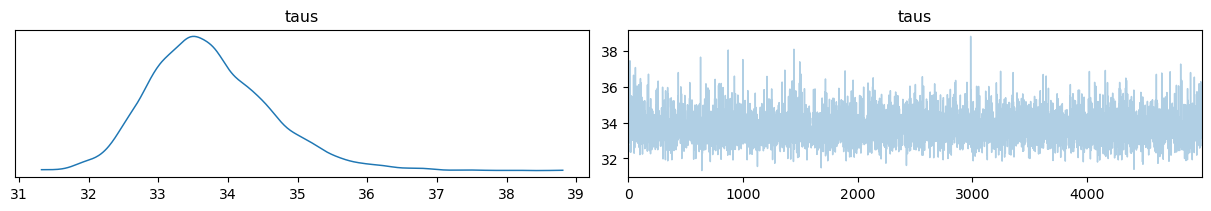

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


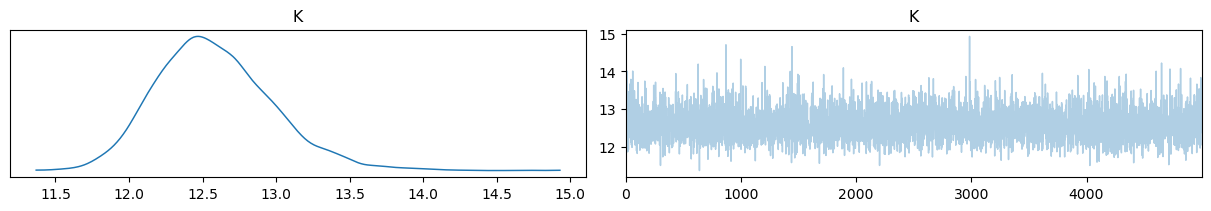

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


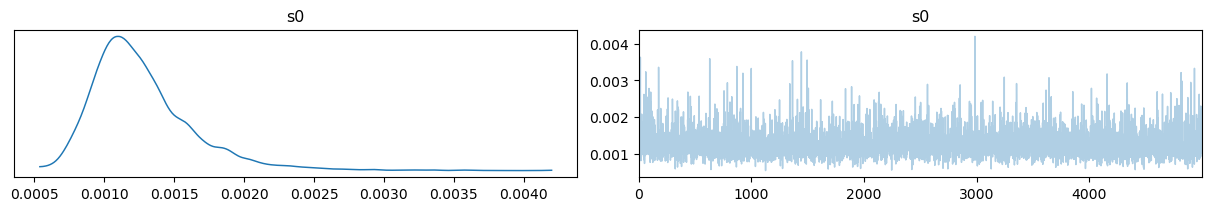

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


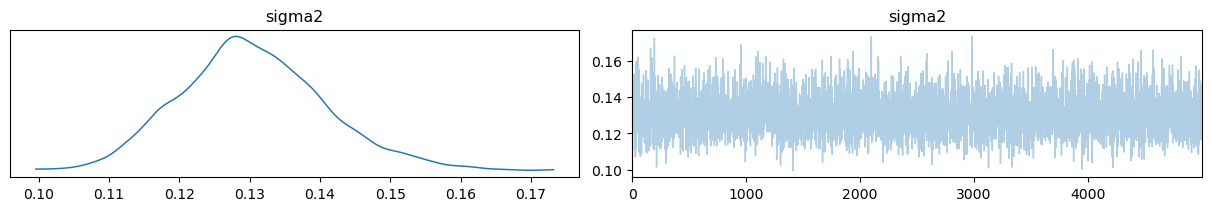

In [9]:
#Plot de cada cadeia

az.plot_trace(trace_calibration1, var_names=('taus'))
plt.savefig('cadeia-tau_s_4000-gompertz.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('K'))
plt.savefig('cadeia-K_4000-gompertz-crescimento.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('s0'))
plt.savefig('cadeia-s0_4000-gompertz-crescimento.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('sigma2'))
plt.savefig('cadeia-sigma2_4000-gompertz-crescimento.png')
plt.show()

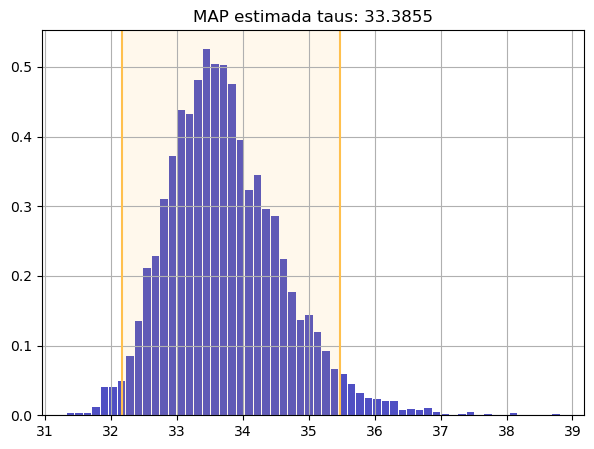

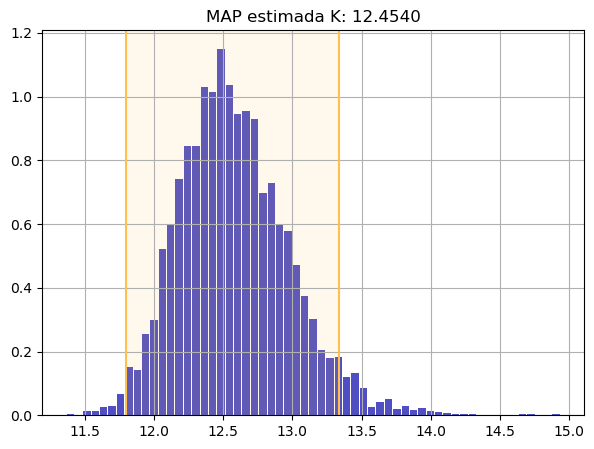

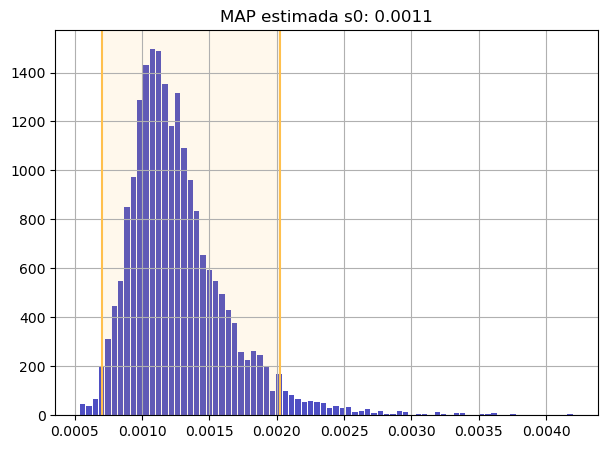

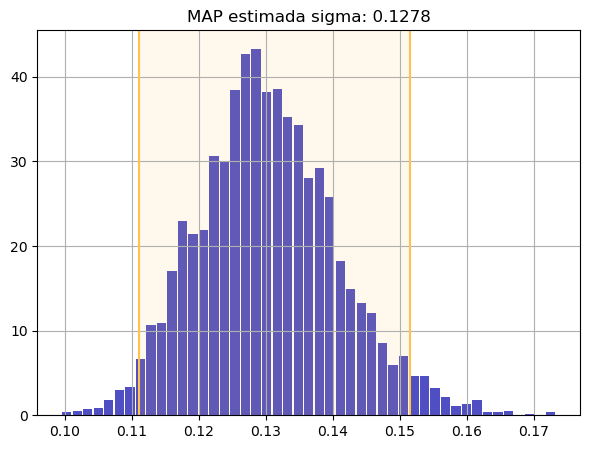

In [10]:
import arviz

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['taus'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['taus'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada taus: {0:.4f}'.format(bins[np.argmax(n)]) )
plt.grid()

plt.savefig('MAP_taus_sensiveis-gompertz_crescimento.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['K'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['K'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada K: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()
#plt.legend()

plt.savefig('MAP_K_sensiveis-gompertz-crescimento.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['s0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['s0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada s0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_s0_sensiveis-gompertz-crescimento.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['sigma2'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['sigma2'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada sigma: {0:.4f}'.format(bins[np.argmax(n)]))
    
plt.grid()
#plt.legend()

plt.savefig('MAP_sigma2_sensiveis-gompertz-crescimento.png')
plt.show()

In [11]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration1["model01"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration1["model01"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration1["model01"], 50, axis=0)

In [12]:
y_min[0:88]

print(len(y_min[0:88]))

minimo = np.reshape(y_min[0:88], (88,))

print(len(minimo))

y_max[0:88]

print(len(y_max[0:88]))

maximo = np.reshape(y_max[0:88], (88,))

print(len(maximo))

y_fit[0:88]

print(len(y_fit[0:88]))

fit = np.reshape(y_fit[0:88], (88,))

print(len(fit))

1
88
1
88
1
88


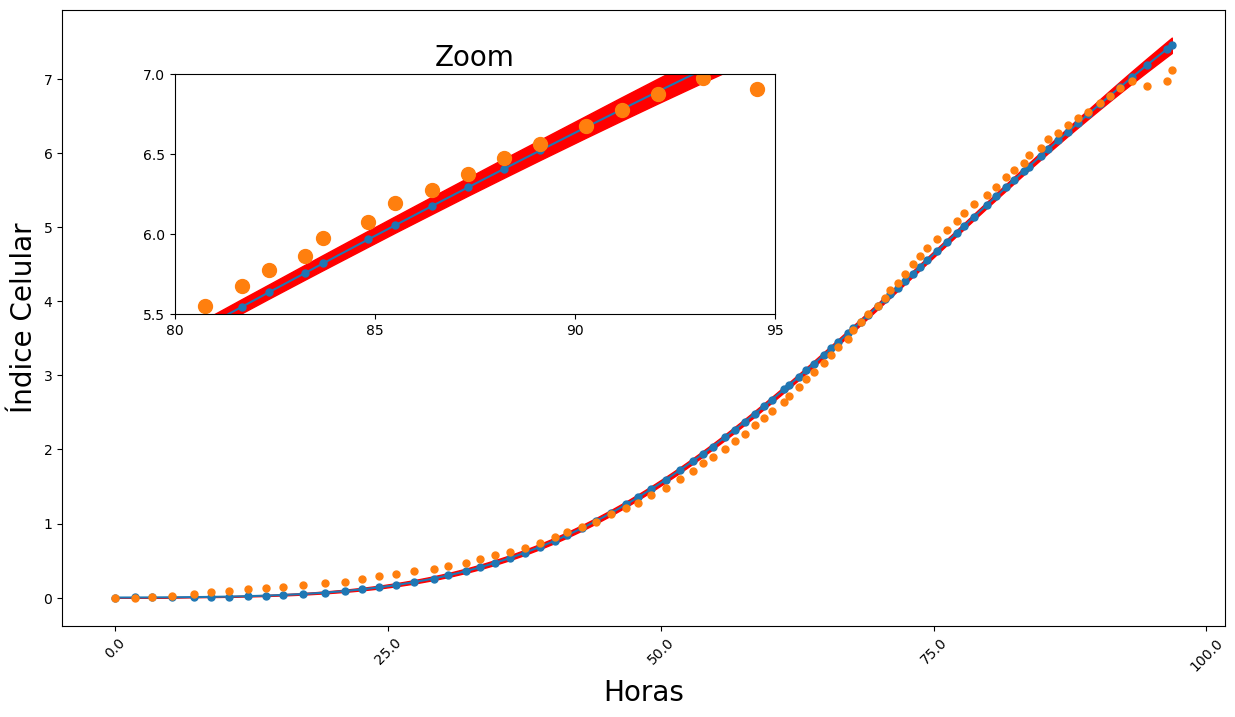

In [13]:
plt.figure(figsize=(15, 8))

# criação do primeiro conjunto de eixos
ax1 = plt.axes() 
ax1.plot(
    xdados2,
    fit,
    label="Simulação",
    marker=".",
    linestyle="-",
    markersize=10,
)
ax1.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax1.plot(
    xdados2, ydados2, label="Dados células sensíveis (2)", marker="o", linestyle="", markersize=5
)
#plt.grid()
t = np.linspace(0, 100, 5)
#ax1.legend(shadow=True)
ax1.set_xticks(t)
ax1.set_xticklabels(t, rotation=45)
ax1.set_xlabel('Horas', fontsize=20)
ax1.set_ylabel('Índice Celular', fontsize=20)

#plt.legend(loc="lower right")

# criação do segundo conjunto de eixos
ax2 = plt.axes([0.2, 0.5, 0.4, 0.3])
ax2.plot(xdados2, fit, marker=".", linestyle="-", markersize=10)
ax2.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax2.plot(xdados2, ydados2,  marker="o", linestyle="", markersize=10)
ax2.set_xlim(80.0, 95.0)
ax2.set_ylim(5.5, 7.0)
ax2.set_xticks([80.0, 85.0, 90.0, 95.0])
ax2.set_yticks([5.5, 6.0, 6.5, 7.0])
#ax2.set_xlabel('Horas', fontsize=15)
#ax2.set_ylabel('Índice Celular', fontsize=15)
ax2.set_title('Zoom', fontsize=20)

plt.savefig('matplotlib_sensiveis4000-gompertz_crescimento.png')

plt.show()

In [14]:
#Critério BIC

soma_gomp = sum((fit - ydados2)**2.0)

def bic(sum_qd, qt_params, vec_size):
    
    return (vec_size * np.log(sum_qd / vec_size) + qt_params * np.log(vec_size))

bic_result = bic(soma_gomp,4,88)

print(bic_result)

-346.7462071976518


In [16]:
bic_result - (-542.7609)

196.01469280234818